2018-04-19 23:24:27,027 - Graph dataframe - INFO - Starting Plot Dataframe
2018-04-19 23:24:27,029 - freqtrade.strategy.strategy - INFO - Load strategy class: DefaultStrategy (user_data.strategies.trend001.py)


[[0.08909374 0.08879488 0.08870004 ... 0.1044104  0.1041043  0.10441057]
 [0.08572454 0.08572804 0.08573154 ... 0.13608108 0.13608458 0.13608808]
 [0.08797845 0.0879794  0.08798035 ... 0.10165524 0.10165619 0.10165714]]
[[0.08909374 0.08879488 0.08870004 ... 0.1044104  0.1041043  0.10441057]
 [0.09264225 0.09264232 0.09264239 ... 0.09365268 0.09365275 0.09365282]
 [0.0878582  0.08785922 0.08786025 ... 0.10260882 0.10260984 0.10261087]]
[[0.08909374 0.08879488 0.08870004 ... 0.1044104  0.1041043  0.10441057]
 [0.09466547 0.09466499 0.09466451 ... 0.08774445 0.08774397 0.08774349]
 [0.09315849 0.0931577  0.09315692 ... 0.08188671 0.08188593 0.08188514]]
[[0.08909374 0.08879488 0.08870004 ... 0.1044104  0.1041043  0.10441057]
 [0.08841109 0.088412   0.08841291 ... 0.10147938 0.10148029 0.1014812 ]
 [0.07880651 0.0788085  0.07881048 ... 0.10739518 0.10739717 0.10739915]]
[[0.08909374 0.08879488 0.08870004 ... 0.1044104  0.1041043  0.10441057]
 [0.09415235 0.09415244 0.09415254 ... 0.095527

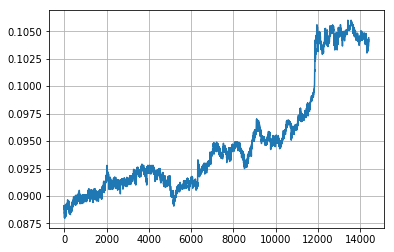

In [2]:
#!/usr/bin/env python3
"""
Script to display when the bot will buy a specific pair

Mandatory Cli parameters:
-p / --pair: pair to examine

Optional Cli parameters
-s / --strategy: strategy to use
-d / --datadir: path to pair backtest data
--timerange: specify what timerange of data to use.
-l / --live: Live, to download the latest ticker for the pair
"""

import sys
from argparse import Namespace

from typing import List

from plotly import tools
from plotly.offline import plot
import plotly.graph_objs as go

from freqtrade.arguments import Arguments
from freqtrade.analyze import Analyze
from freqtrade import exchange
from freqtrade.logger import Logger
import freqtrade.optimize as optimize
from freqtrade.indicators import get_trend_lines
import numpy as np


logger = Logger(name="Graph dataframe").get_logger()


def plot_analyzed_dataframe(args: Namespace) -> None:
    """
    Calls analyze() and plots the returned dataframe
    :return: None
    """

    pair = args.pair.replace('-', '_')
    timerange = Arguments.parse_timerange(args.timerange)

    # Init strategy
    try:
        analyze = Analyze({'strategy': args.strategy})
    except AttributeError:
        logger.critical(
            'Impossible to load the strategy. Please check the file "user_data/strategies/%s.py"',
            args.strategy
        )
        exit()

    tick_interval = analyze.strategy.ticker_interval

    tickers = {}
    if args.live:
        logger.info('Downloading pair.')
        # Init Bittrex to use public API
        exchange.init({'key': '', 'secret': ''})
        tickers[pair] = exchange.get_ticker_history(pair, tick_interval)
    else:
        tickers = optimize.load_data(
            datadir=args.datadir,
            pairs=[pair],
            ticker_interval=tick_interval,
            refresh_pairs=False,
            timerange=timerange
        )
    dataframes = analyze.tickerdata_to_dataframe(tickers)
    dataframe = dataframes[pair]
    dataframe, trends_x_max, trends_max, trends_x_min, trends_min = analyze.populate_trend_lines(dataframe, pair)
    dataframe = analyze.populate_buy_trend(dataframe)
    df = dataframe = analyze.populate_sell_trend(dataframe)

#     if len(dataframe.index) > 750:
#         logger.warning('Ticker contained more than 750 candles, clipping.')
    data = dataframe

    candles = go.Candlestick(
        x=data.date,
        open=data.open,
        high=data.high,
        low=data.low,
        close=data.close,
        name='Price'
    )

    df_buy = data[data['buy'] == 1]
    buys = go.Scattergl(
        x=df_buy.date,
        y=df_buy.close,
        mode='markers',
        name='buy',
        marker=dict(
            symbol='triangle-up-dot',
            size=9,
            line=dict(width=1),
            color='green',
        )
    )
    df_sell = data[data['sell'] == 1]
    sells = go.Scattergl(
        x=df_sell.date,
        y=df_sell.close,
        mode='markers',
        name='sell',
        marker=dict(
            symbol='triangle-down-dot',
            size=9,
            line=dict(width=1),
            color='red',
        )
    )

    bb_lower = go.Scatter(
        x=data.date,
        y=data.bb_lowerband,
        name='BB lower',
        line={'color': "transparent"},
    )
    bb_upper = go.Scatter(
        x=data.date,
        y=data.bb_upperband,
        name='BB upper',
        fill="tonexty",
        fillcolor="rgba(0,176,246,0.2)",
        line={'color': "transparent"},
    )
    macd = go.Scattergl(x=data['date'], y=data['macd'], name='MACD')
    macdsignal = go.Scattergl(x=data['date'], y=data['macdsignal'], name='MACD signal')
    volume = go.Bar(x=data['date'], y=data['volume'], name='Volume')

    fig = tools.make_subplots(
        rows=3,
        cols=1,
        shared_xaxes=True,
        row_width=[1, 1, 4],
        vertical_spacing=0.0001,
    )
    
    
    # Print support and resistances horizontal lines

    sup_lines = []
    sup = np.unique(df['s1'].dropna().values)
    # print ('supports: ', df['s1'].dropna().values)
    for i in range(0, len(sup)):
        # print (sup[i])
        fig.append_trace(go.Scatter(
            x = [df['date'][0],df['date'][-1]],
            y = [sup[i],sup[i]],
            line = dict(color = 'rgba(147,112,219,0.5)'),
            mode = 'line',
            name = 'sup '+ str(sup[i])
        ), 1, 1)

    res_lines = []
    res = np.unique(df['r1'].dropna().values)
    for i in range(0, len(res)):
        # print (pivots[i])
        fig.append_trace(go.Scatter(
            x = [df['date'][0],df['date'][-1]],
            y = [res[i],res[i]],
            line = dict(color = 'rgba(23, 190, 207,0.5)'),
            mode = 'line',
            name = 'res '+ str(res[i])
        ), 1, 1)


    # Trend lines
    
    # print(trends_max.tolist())
    # print(trends_x_max.tolist())
    # print(list(df.date[df.index.isin(trends_x_max)]))
    #
    fig.append_trace(go.Scatter(
        x = list(df.date[df.index.isin(trends_x_max)]),
        y = trends_max.tolist(),
        line = dict(color = 'black'),
        mode = 'line',
        name = 'trend max'
    ), 1, 1)
    fig.append_trace(go.Scatter(
        x = list(df.date[df.index.isin(trends_x_min)]),
        y = trends_min.tolist(),
        line = dict(color = 'black'),
        mode = 'line',
        name = 'trend min'
    ), 1, 1)

        
        
    fig.append_trace(candles, 1, 1)
    fig.append_trace(bb_lower, 1, 1)
    fig.append_trace(bb_upper, 1, 1)
    fig.append_trace(buys, 1, 1)
    fig.append_trace(sells, 1, 1)
    fig.append_trace(volume, 2, 1)
    fig.append_trace(macd, 3, 1)
    fig.append_trace(macdsignal, 3, 1)

    fig['layout'].update(title=args.pair)
    fig['layout']['yaxis1'].update(title='Price')
    fig['layout']['yaxis2'].update(title='Volume')
    fig['layout']['yaxis3'].update(title='MACD')

    plot(fig, filename='freqtrade-plot.html')


def plot_parse_args(args: List[str]) -> Namespace:
    """
    Parse args passed to the script
    :param args: Cli arguments
    :return: args: Array with all arguments
    """
    arguments = Arguments(args, 'Graph dataframe')
    arguments.scripts_options()
    arguments.common_args_parser()
    arguments.optimizer_shared_options(arguments.parser)
    arguments.backtesting_options(arguments.parser)

    return arguments.parse_args()


def main(sysargv: List[str]) -> None:
    """
    This function will initiate the bot and start the trading loop.
    :return: None
    """
    logger.info('Starting Plot Dataframe')
    plot_analyzed_dataframe(
        plot_parse_args(sysargv)
    )


if __name__ == '__main__':
    sys.argv[1:]=['-s', 'trend001', '-p', 'ETH/BTC']
    main(sys.argv[1:])


In [1]:
p = np.poly1d([2, 2, 3])
print(np.poly1d(p))

NameError: name 'np' is not defined